In [29]:
import os

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split  


import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

# Plots/Tables
1. Expectation model
    - Table showing kickers with highest fgoe
3. Kicker Specific Model (for fourth down decision model)
    - probabily plots demonstrating difference in probability against distance
    - Table showing the teams that were most aggressive in going for low probability field goals

# Process:
1. Logistic regression trained for each kick, (or maybe bagged and trained on every 100 kicks) for temporal split
2. Calculate FGPOE at the time of each kick
3. Feed FGPOE, environmental factors, and situational factors into heirachical baysian logistic regression

# Features
* environmental factors
    * temperature
    * precipitation
    * wind 
        * figure out a way to factor in direciton
    * headwind speed (away or towards)
    * sidewind speed
    * altitude
    * field surface
* situational factors
    * regular verse post season
    * situational pressure (score and time remaining)
        * ot, end of half, with tie or win the game
    * home vers away
    * icing
    * kicking direction
* kicker ability
    fg% over average model


# Notes
* field goal post height increased to 5ft in 2014 (so only take 2014 on)

# Approach
1. An ensamble of models. One that first predicts FG% over expectation and then that feeds into overall model as predictor
    * two models: on that is predicts proba for 'average' kicker and one that is kicker specific


# TODO
* figure out if you need to adjust pre 2014 data based on field goal height, because you need that data for the first model
* then plot probability of field goal sucess by distance


In [3]:
years = range(2000, 2024)
# cols = nfl.see_pbp_cols()

In [4]:
df_pbp = nfl.import_pbp_data(years)
df_pbp[df_pbp['field_goal_attempt'] == True].shape

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


(24471, 390)

In [37]:
for c in df_pbp.columns:
    if 'field' in c:
        print(c)

side_of_field
field_goal_result
field_goal_attempt


In [38]:
df.field_goal_result.value_counts()

field_goal_result
made       20259
missed      3688
blocked      524
Name: count, dtype: int64

In [22]:
df_pbp.head(1)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

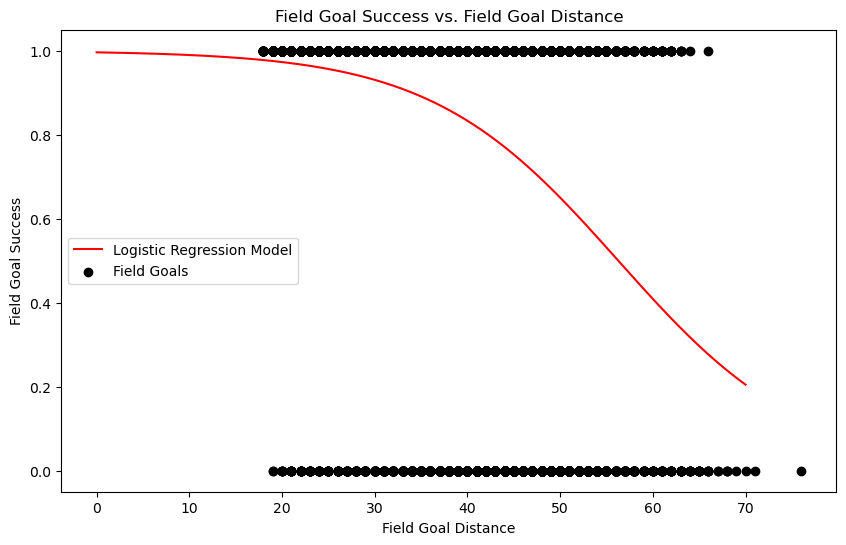

In [58]:
# train a logistic regression model to predict field goal success using field goal distance
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True]
df_fg = df_fg[['kick_distance', 'field_goal_result']]
df_fg = df_fg.dropna()
df_fg['field_goal_result'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

X = df_fg['kick_distance'].values.reshape(-1, 1)
y = df_fg['field_goal_result'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  

model = sk.linear_model.LogisticRegression()
model.fit(X_train, y_train)

# plot the logistic regression model
plt.figure(figsize=(10, 6))

X_test = np.linspace(0, 70, 1000).reshape(-1, 1)
y_pred = model.predict_proba(X_test)[:, 1]

plt.plot(X_test, y_pred, color='red', label='Logistic Regression Model')
plt.scatter(X, y, color='black', label='Field Goals')
plt.xlabel('Field Goal Distance')
plt.ylabel('Field Goal Success')
plt.title('Field Goal Success vs. Field Goal Distance')
plt.legend()

/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukeneuendorf/m

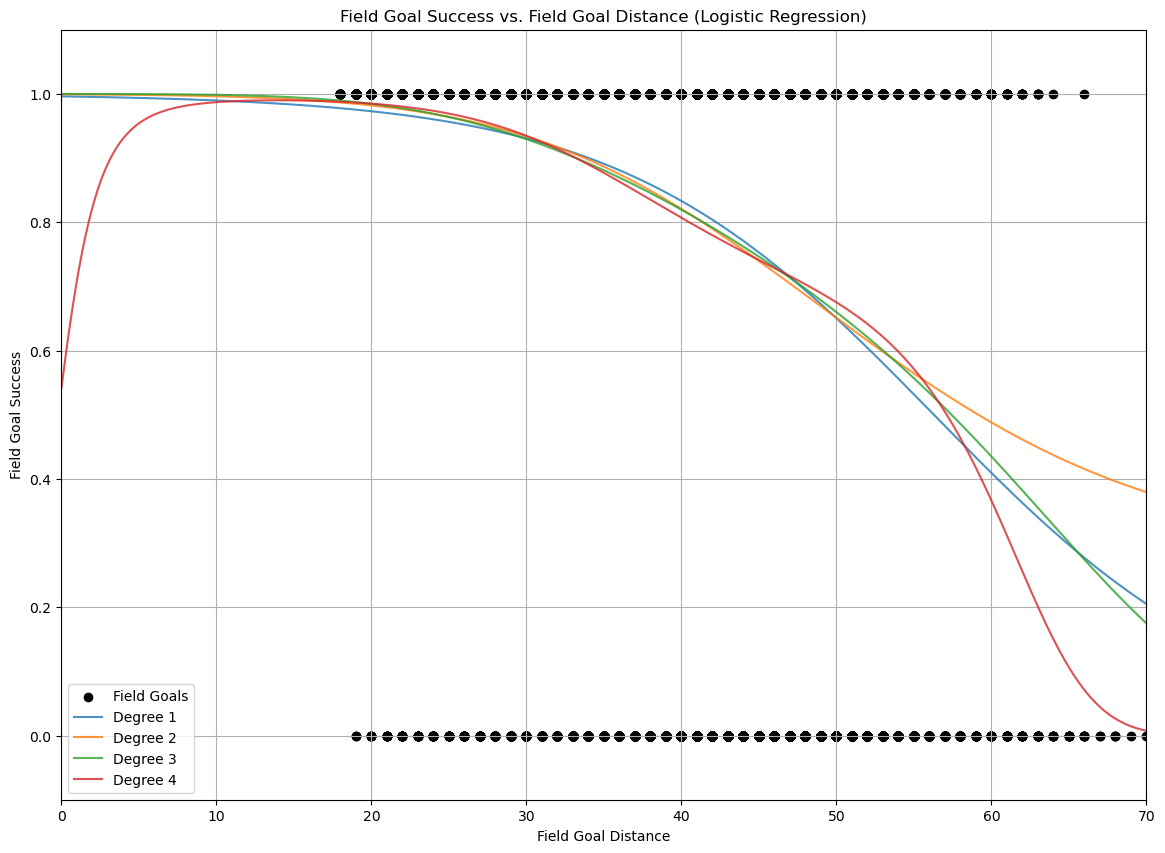

Degree 1 - Train Accuracy: 0.830, Test Accuracy: 0.833
Degree 1 - Train ROC AUC: 0.748, Test ROC AUC: 0.757
0.2051592783686689
0.08771592564751121
0.03457822921477223

Degree 2 - Train Accuracy: 0.829, Test Accuracy: 0.832
Degree 2 - Train ROC AUC: 0.748, Test ROC AUC: 0.757
0.37947993991723405
0.3300104179739748
0.3324422824238232

Degree 3 - Train Accuracy: 0.831, Test Accuracy: 0.832
Degree 3 - Train ROC AUC: 0.748, Test ROC AUC: 0.757
0.17481850268330357
0.02935303155705329
0.00167107005820114

Degree 4 - Train Accuracy: 0.831, Test Accuracy: 0.832
Degree 4 - Train ROC AUC: 0.748, Test ROC AUC: 0.757
0.00745231694171388
9.664099378504659e-08
6.659021557012556e-18



/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid featu

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Example data preparation (replace with your dataset loading and cleaning)
# Assuming df_pbp contains your dataset with field goal attempts
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True]
df_fg = df_fg[['kick_distance', 'field_goal_result']]
df_fg = df_fg.dropna()
df_fg['field_goal_result'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

# Extracting features and target
X = df_fg[['kick_distance']]
y = df_fg['field_goal_result']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Define degrees of polynomial features to test
degrees = [1, 2, 3, 4]

plt.figure(figsize=(14, 10))

# Plot original data points
plt.scatter(X, y, color='black', label='Field Goals')

# Loop over degrees and fit models
for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    
    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X_poly_train, y_train)
    
    # Predict probabilities for plotting the logistic regression curve
    X_test_plot = np.linspace(0, 70, 1000).reshape(-1, 1)
    X_test_plot_poly = poly.transform(X_test_plot)
    y_pred_plot = model.predict_proba(X_test_plot_poly)[:, 1]
    
    # Plot logistic regression curve
    plt.plot(X_test_plot, y_pred_plot, label=f'Degree {degree}', alpha=0.8)

# Plot settings
plt.xlabel('Field Goal Distance')
plt.ylabel('Field Goal Success')
plt.title('Field Goal Success vs. Field Goal Distance (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.ylim([-0.1, 1.1])
plt.xlim([0, 70])
plt.show()

# Evaluation metrics
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    
    model = LogisticRegression()
    model.fit(X_poly_train, y_train)
    
    y_pred_train = model.predict(X_poly_train)
    y_pred_test = model.predict(X_poly_test)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_poly_train)[:, 1])
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_poly_test)[:, 1])
    
    print(f"Degree {degree} - Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")
    print(f"Degree {degree} - Train ROC AUC: {roc_auc_train:.3f}, Test ROC AUC: {roc_auc_test:.3f}")
    print(model.predict_proba(poly.transform([[70]]))[0][1])
    print(model.predict_proba(poly.transform([[80]]))[0][1])
    print(model.predict_proba(poly.transform([[90]]))[0][1])
    print()


In [60]:
%time
model = LogisticRegression()
model.fit(X, y)

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 10 μs


LogisticRegression()

In [37]:
# create a funciton which generates a logistic regression model for field goal success using kick_distance given X and y
from sklearn.linear_model import LogisticRegression

def fit_logistic_regression(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

# create a model for the data up to that year
def create_model(df, year):
    df_fg = df[df['field_goal_attempt'] == True]
    df_fg = df_fg[['kick_distance', 'field_goal_result']]
    df_fg = df_fg.dropna()
    df_fg['field_goal_result'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

    X = df_fg['kick_distance'].values.reshape(-1, 1)
    y = df_fg['field_goal_result'].values

    model = fit_logistic_regression(X, y)
    return model

# create a model for each year
models = {} 

for year in years[1:]:
    df_year = df_pbp[df_pbp['season'] <= year]
    models[year] = create_model(df_year, year)

In [38]:
for year in years[1:]:
    print(round(models[year].predict_proba(np.array([[50]]))[0][0], 3))

0.467
0.478
0.472
0.462
0.456
0.449
0.444
0.434
0.433
0.428
0.419
0.408
0.397
0.392
0.385
0.381
0.374
0.371
0.372
0.367
0.362
0.356
0.35


In [5]:
variables = ['season','play_id','game_id','desc','kicker_player_name', 'kicker_player_id', 'field_goal_attempt', 
             'extra_point_attempt', 'fg_prob', 'field_goal_result', 'kick_distance']

df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

In [6]:
df_schedules = nfl.import_schedules(years)

sched_cols = ['game_id','roof','surface','wind','temp','stadium_id','stadium']
df = df_fg.merge(df_schedules[sched_cols], on='game_id', how='left')

In [7]:
df['field_goal_made'] = df['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)
df.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,roof,surface,wind,temp,stadium_id,stadium,field_goal_made
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,outdoors,grass,3.0,80.0,NYC00,Giants Stadium,1
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,1
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,1
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,1
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_6077/3337300163.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fg_success_pct = df.groupby('distance_bin')['field_goal_made'].mean()


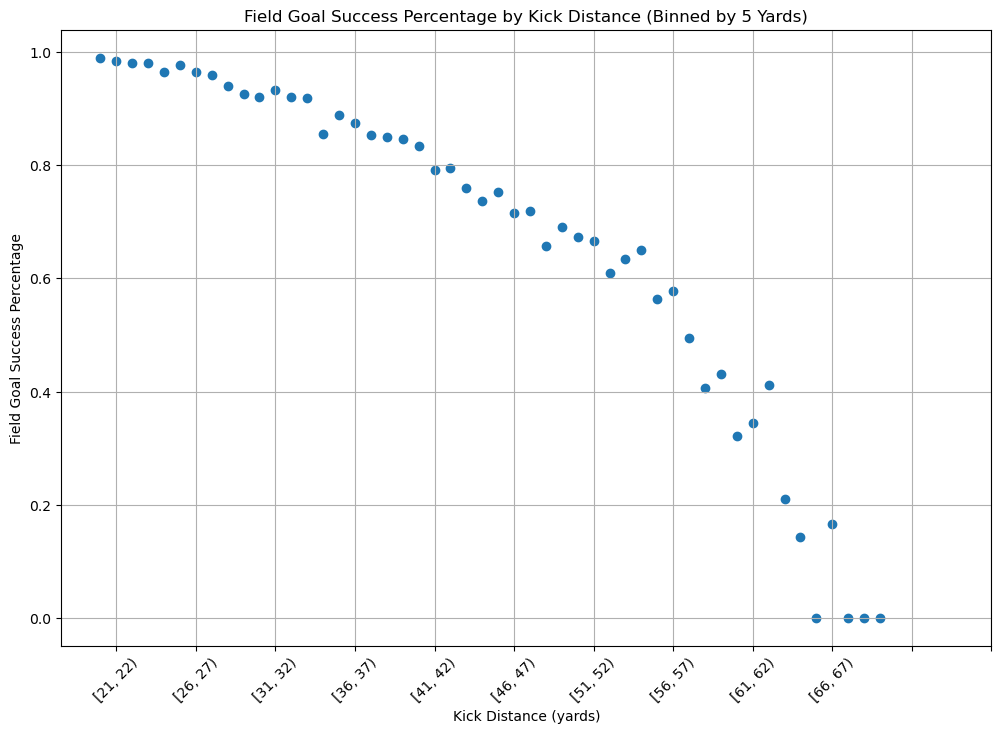

In [8]:
# generate plot of field goal sucess percentage binned by kick distance
import matplotlib.pyplot as plt
import seaborn as sns

# Bin the kick distance
bins = range(20, 71, 1)
df['distance_bin'] = pd.cut(df['kick_distance'], bins=bins, right=False)

# Calculate the field goal success percentage for each distance bin
fg_success_pct = df.groupby('distance_bin')['field_goal_made'].mean()

x = fg_success_pct.index.astype(str)
y = fg_success_pct

# Plot the field goal success percentage by distance
plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.xlabel('Kick Distance (yards)')
plt.ylabel('Field Goal Success Percentage')
plt.title('Field Goal Success Percentage by Kick Distance (Binned by 5 Yards)')
plt.xticks(np.arange(1, 60, 5.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [9]:
#count the number of field goals attempted and made by distance
df['field_goal_made'] = df['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)
df_fg = df[df['field_goal_attempt'] == True]
df_fg = df_fg.groupby('kick_distance').agg({'field_goal_attempt':'count','field_goal_made':'sum'}).reset_index()
df_fg = (df_fg.sort_values(by='kick_distance', ascending=True)
              .rename({'field_goal_attempt':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))
df_fg.head()

,kick_distance,field_goal_attempts,field_goal_makes
0,18.0,34,34
1,19.0,239,237
2,20.0,495,490
3,21.0,524,516
4,22.0,629,617


In [10]:
# Import necessary libraries
import pymc as pm
import numpy as np
import pandas as pd

# Assuming df_fg is your DataFrame
# Example structure (use your actual data instead):
# df_fg = pd.DataFrame({
#     'kick_distance': [30, 40, 50, 60, 70],
#     'field_goal_attempts': [10, 20, 30, 25, 15],
#     'field_goal_makes': [9, 15, 20, 10, 5]
# })

# Extract the data
kick_distance = df_fg['kick_distance'].values
attempts = df_fg['field_goal_attempts'].values
makes = df_fg['field_goal_makes'].values

# Define the logistic regression model using PyMC
with pm.Model() as logistic_model:
    # Priors for the logistic regression coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)
    
    # Logistic model for the probability of making a field goal
    logit_p = intercept + slope * kick_distance
    p = pm.math.sigmoid(logit_p)
    
    # Binomial likelihood function for the observed data
    likelihood = pm.Binomial('likelihood', n=attempts, p=p, observed=makes)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Display the results
print(pm.summary(trace))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.599  0.093   5.422    5.774      0.002    0.002    1806.0   
slope     -0.100  0.002  -0.103   -0.095      0.000    0.000    1810.0   

           ess_tail  r_hat  
intercept    1661.0    1.0  
slope        1712.0    1.0  


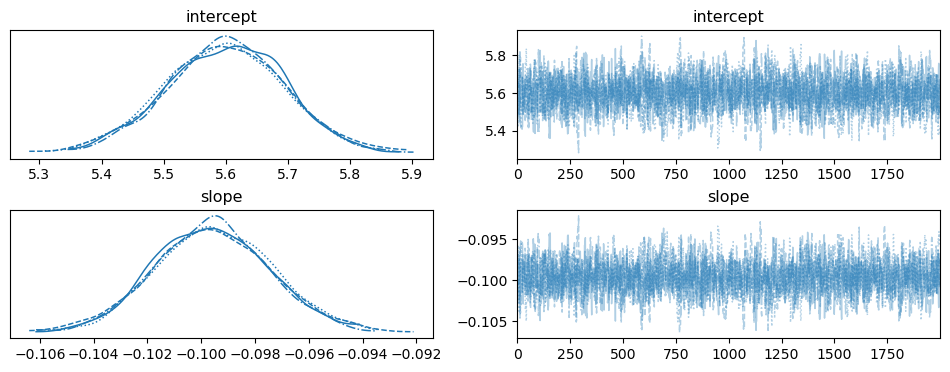

In [11]:
axes = pm.plot_trace(trace)
plt.subplots_adjust(hspace=.4)
plt.show()

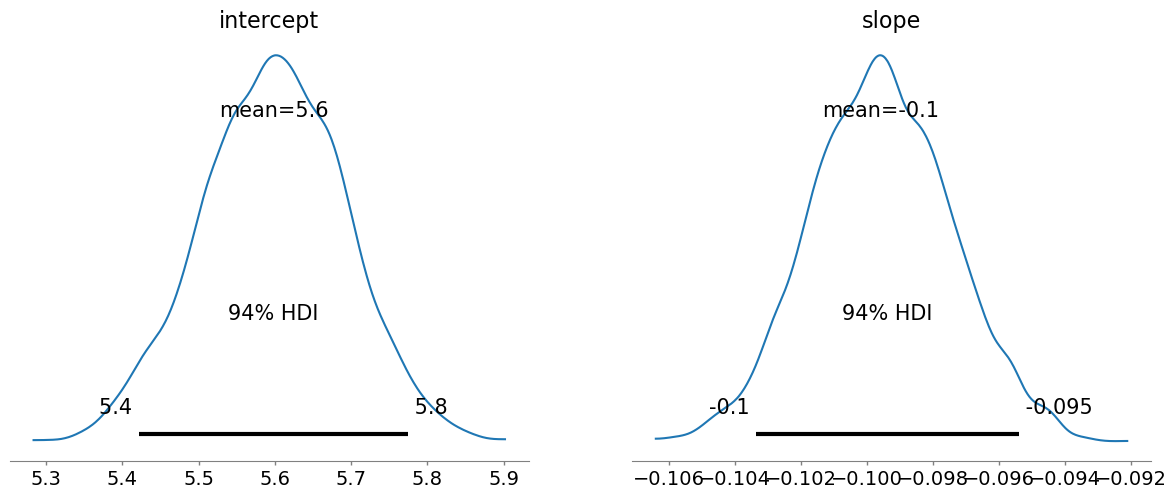

In [12]:
import pymc as pm
import matplotlib.pyplot as plt

# Assuming 'trace' is already obtained from your PyMC sampling

# Plot the posterior distributions
pm.plot_posterior(trace)

# Display the plots
plt.show()

Sampling: [intercept, likelihood, slope]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


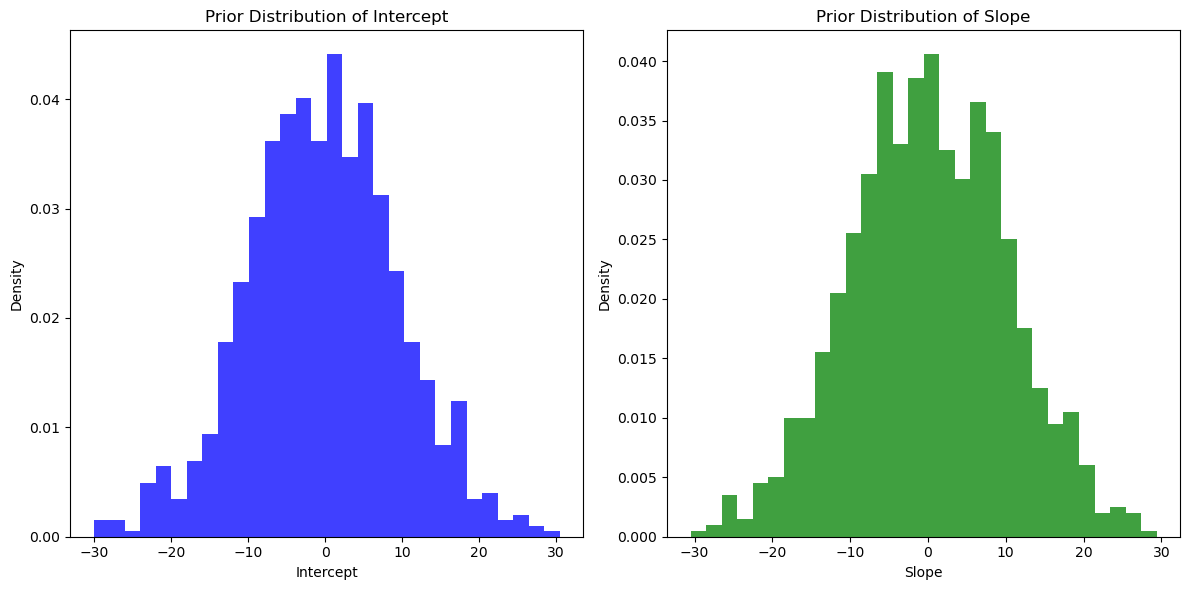

In [13]:
# Import necessary libraries
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_fg is your DataFrame (use your actual data instead)
# Example structure:
# df_fg = pd.DataFrame({
#     'kick_distance': [30, 40, 50, 60, 70],
#     'field_goal_attempts': [10, 20, 30, 25, 15],
#     'field_goal_makes': [9, 15, 20, 10, 5]
# })

# Extract the data
kick_distance = df_fg['kick_distance'].values
attempts = df_fg['field_goal_attempts'].values
makes = df_fg['field_goal_makes'].values

# Define the logistic regression model using PyMC
with pm.Model() as logistic_model:
    # Priors for the logistic regression coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)
    
    # Logistic model for the probability of making a field goal
    logit_p = intercept + slope * kick_distance
    p = pm.math.sigmoid(logit_p)
    
    # Binomial likelihood function for the observed data
    likelihood = pm.Binomial('likelihood', n=attempts, p=p, observed=makes)
    
    # Sample from the priors
    prior_samples = pm.sample_prior_predictive(samples=1000)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Plot the prior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the prior for the intercept
axes[0].hist(prior_samples.prior['intercept'].values[0], bins=30, density=True, alpha=0.75, color='blue')
axes[0].set_title('Prior Distribution of Intercept')
axes[0].set_xlabel('Intercept')
axes[0].set_ylabel('Density')

# Plot the prior for the slope
axes[1].hist(prior_samples.prior['slope'].values[0], bins=30, density=True, alpha=0.75, color='green')
axes[1].set_title('Prior Distribution of Slope')
axes[1].set_xlabel('Slope')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()



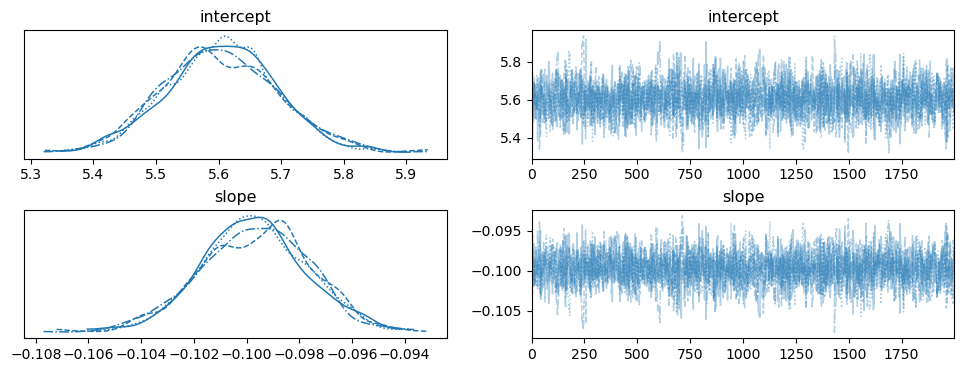

In [23]:
axes = pm.plot_trace(trace)
plt.subplots_adjust(hspace=.4)
plt.show()

In [14]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_fg is your DataFrame (use your actual data instead)
# Example structure:
# df_fg = pd.DataFrame({
#     'kick_distance': [30, 40, 50, 60, 70],
#     'field_goal_attempts': [10, 20, 30, 25, 15],
#     'field_goal_makes': [9, 15, 20, 10, 5]
# })

# Extract the data
kick_distance = df_fg['kick_distance'].values
attempts = df_fg['field_goal_attempts'].values
makes = df_fg['field_goal_makes'].values

# Define a function to adjust the probability based on distance
def adjust_probability(distance, probability):
    # Penalize long distances where no field goals have been made
    return probability * (1 + 1.2 * (distance >= 60))  # Adjust the penalty factor as needed

# Define the logistic regression model using PyMC
with pm.Model() as logistic_model:
    # Priors for the logistic regression coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)
    
    # Logistic model for the probability of making a field goal
    logit_p = intercept + slope * kick_distance
    p = pm.math.sigmoid(logit_p)
    
    # Adjusted probability based on distance
    adjusted_p = adjust_probability(kick_distance, p)
    
    # Binomial likelihood function for the observed data
    likelihood = pm.Binomial('likelihood', n=attempts, p=adjusted_p, observed=makes)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Extract the posterior samples
posterior_intercept_samples = trace.posterior['intercept'].values.flatten()
posterior_slope_samples = trace.posterior['slope'].values.flatten()

# Generate predictions for the observed kick distances
predicted_probs = []

# Loop over each kick distance and compute predicted probabilities using posterior samples
for distance in kick_distance:
    logit_p_samples = posterior_intercept_samples + posterior_slope_samples * distance
    p_samples = 1 / (1 + np.exp(-logit_p_samples))  # logistic function
    predicted_probs.append(p_samples)

# Convert the list of predicted probabilities to a numpy array for easier manipulation
predicted_probs = np.array(predicted_probs)

# Compute the mean and 95% credible intervals for the predicted probabilities
mean_probs = np.mean(predicted_probs, axis=1)
lower_cred_interval = np.percentile(predicted_probs, 2.5, axis=1)
upper_cred_interval = np.percentile(predicted_probs, 97.5, axis=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


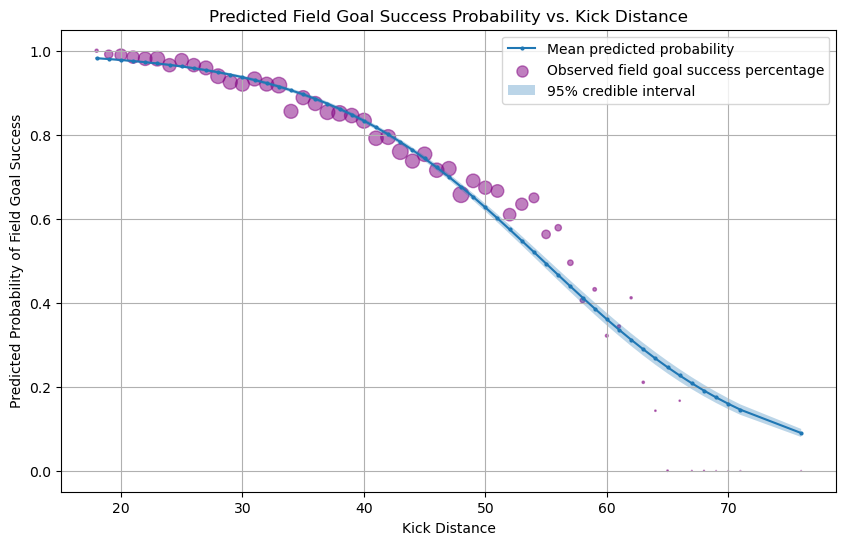

In [15]:
df_fg['fg_pct'] = df_fg['field_goal_makes'] / df_fg['field_goal_attempts']
# Extract the kick distances (as integers) and corresponding success percentages
x = df_fg['kick_distance'].values
y = df_fg['fg_pct'].values
marker_sizes = df_fg['field_goal_attempts'].values * .15
plt.figure(figsize=(10, 6))
plt.plot(kick_distance, mean_probs, 'o-', markersize=2,label='Mean predicted probability')
plt.scatter(x, y, color='purple', s=marker_sizes, label='Observed field goal success percentage', alpha=0.5)
plt.fill_between(kick_distance, lower_cred_interval, upper_cred_interval, alpha=0.3, label='95% credible interval')
plt.xlabel('Kick Distance')
plt.ylabel('Predicted Probability of Field Goal Success')
plt.title('Predicted Field Goal Success Probability vs. Kick Distance')
plt.legend()
plt.grid()
plt.show()

In [16]:
df_fg

,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,34,34,1.000000
1,19.0,239,237,0.991632
2,20.0,495,490,0.989899
3,21.0,524,516,0.984733
4,22.0,629,617,0.980922
5,23.0,734,720,0.980926
6,24.0,609,588,0.965517
7,25.0,620,606,0.977419
8,26.0,612,591,0.965686
9,27.0,660,633,0.959091


For kick \( i \) by kicker \( j \) in game \( k \):

$
\text{logit}(p_{ijk}) = \beta_0 + u_j + \beta_1 \text{Distance}_{ijk} + \beta_2 \text{Wind}_{ijk} + \beta_3 \text{Elevation}_{ijk} + \beta_4 \text{Rain}_{ijk} + \beta_5 \text{Temperature}_{ijk} + \beta_6 \text{Pressure}_{ijk} + \beta_7 \text{FG\% Over Expectation}_{ijk}
$

